In [3]:
reInstall = False

if reInstall == True :
    # Installe PyTorch pour CPU
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    # Installe NumPy et tqdm si nécessaire
    !pip install numpy tqdm scikit-learn matplotlib

import torch
import numpy as np
from tqdm import tqdm
print("Installation terminée")
print("torch:", torch.__version__)
print("numpy:", np.__version__)


Installation terminée
torch: 2.7.1+cpu
numpy: 2.1.2


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

# utilise le CPU
device = torch.device("cpu")
print(f"🔧 Appareil utilisé : {device}")

🔧 Appareil utilisé : cpu


In [5]:
class LuSNARDataset(Dataset):
    def __init__(self, folder_path):
        self.files = sorted([f for f in os.listdir(folder_path) if f.endswith(".npz")])
        self.folder_path = folder_path

        # dictionnaire de remapping : -1 → 0, 0 → 1, 174 → 2
        self.label_map = { -1: 0, 0: 1, 174: 2 }

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.files[idx])
        data = np.load(file_path)
        
        points = data["lidar_points"]        # (N, 3)
        labels = data["lidar_category"]      # (N,)

        num_points = 1024
        if len(points) >= num_points:
            indices = np.random.choice(len(points), num_points, replace=False)
        else:
            indices = np.random.choice(len(points), num_points, replace=True)
        
        pts = points[indices]
        lbl_raw = labels[indices]

        # application du mapping
        lbl = np.vectorize(self.label_map.get)(lbl_raw)

        return torch.tensor(pts, dtype=torch.float32), torch.tensor(lbl, dtype=torch.long)


In [6]:
class TNet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2)[0]

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = torch.eye(self.k, device=x.device).view(1, self.k * self.k).repeat(batchsize, 1)
        x = x + iden
        return x.view(-1, self.k, self.k)


In [12]:
class PointNetSeg(nn.Module):
    def __init__(self, num_classes=3):  # regolith, rock, crater
        super().__init__()
        self.input_transform = TNet(k=3)

        self.conv1 = nn.Conv1d(3, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(1024)

        self.conv4 = nn.Conv1d(1088, 512, 1)
        self.bn4 = nn.BatchNorm1d(512)

        self.conv5 = nn.Conv1d(512, 256, 1)
        self.bn5 = nn.BatchNorm1d(256)

        self.dropout = nn.Dropout(p=0.3)
        self.conv6 = nn.Conv1d(256, num_classes, 1)

    def forward(self, x):
        B, N, _ = x.size()
        x = x.transpose(2, 1)  # (B, 3, N)

        # Input transform
        T = self.input_transform(x)
        x = torch.bmm(T, x)

        x = F.relu(self.bn1(self.conv1(x)))         # (B, 64, N)
        pointfeat = x                               # 🔧 on garde ce feature local
        x = F.relu(self.bn2(self.conv2(x)))         # (B, 128, N)
        x = F.relu(self.bn3(self.conv3(x)))         # (B, 1024, N)

        global_feat = torch.max(x, 2, keepdim=True)[0]  # (B, 1024, 1)
        global_feat = global_feat.repeat(1, 1, N)       # (B, 1024, N)

        x = torch.cat([pointfeat, global_feat], 1)      # (B, 64 + 1024 = 1088, N)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout(x)
        x = self.conv6(x)                               # (B, num_classes, N)

        return x.transpose(2, 1).contiguous()           # (B, N, num_classes)



In [11]:
dataset_path = "data/moon"  # à adapter si besoin
batch_size = 16

full_dataset = LuSNARDataset(dataset_path)

val_ratio = 0.1
test_ratio = 0.1

total_size = len(full_dataset)
val_size = int(val_ratio * total_size)
test_size = int(test_ratio * total_size)
train_size = total_size - val_size - test_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # pour reproductibilité
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [47]:
reCalculerPoids = False

from collections import Counter

model = PointNetSeg(num_classes=3).to(device)

if reCalculerPoids:
    print("⏳ Calcul des poids de classes...")
    total_labels = []

    for _, labels in train_loader:
        total_labels.extend(labels.view(-1).tolist())

    counts = Counter(total_labels)
    print("📊 Répartition dans le train :", counts)

    total = sum(counts.values())
    weights = torch.tensor([total / counts[i] for i in range(3)], dtype=torch.float32)
    weights = weights / weights.sum()

else:
    print("📊 Répartition dans le train : Counter({0: 3404410, 2: 454159, 1: 57207})")

    weights = torch.tensor([0.014691609889268875, 0.8755366206169128, 0.1097717434167862])
    weights = weights / weights.sum()


📊 Répartition dans le train : Counter({0: 3404410, 2: 454159, 1: 57207})


In [48]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha  # pondérations de classe (tensor)
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal = (1 - pt) ** self.gamma * ce_loss
        return focal.mean()


In [50]:

# --- définition loss + optimiseur
criterion = FocalLoss(alpha=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"✅ Poids utilisés pour la loss : {weights.tolist()}")


✅ Poids utilisés pour la loss : [0.01469161082059145, 0.8755366802215576, 0.10977175086736679]


In [51]:
reTrain = True

import copy

num_epochs = 30
best_miou = 0.0
patience = 5
patience_counter = 0
SAVE_PATH = "pointnet_best_miou.pt"
best_model = None

if reTrain == True:
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0

        for points, labels in tqdm(train_loader, desc=f"🧪 Epoch {epoch} [train]"):
            points, labels = points.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(points)
            loss = criterion(outputs.view(-1, 3), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        correct = total = 0
        preds_all, labels_all = [], []

        with torch.no_grad():
            for points, labels in val_loader:
                points, labels = points.to(device), labels.to(device)
                outputs = model(points)

                val_loss += criterion(outputs.view(-1, 3), labels.view(-1)).item()
                preds = outputs.argmax(dim=2)

                correct += (preds == labels).sum().item()
                total += labels.numel()

                preds_all.append(preds.cpu().numpy())
                labels_all.append(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        # mIoU
        y_true = np.concatenate(labels_all).flatten()
        y_pred = np.concatenate(preds_all).flatten()
        ious = []
        for cls in range(3):
            tp = np.logical_and(y_pred == cls, y_true == cls).sum()
            fp = np.logical_and(y_pred == cls, y_true != cls).sum()
            fn = np.logical_and(y_pred != cls, y_true == cls).sum()
            denom = tp + fp + fn
            iou = tp / denom if denom != 0 else float("nan")
            ious.append(iou)

        val_miou = np.nanmean(ious)

        print(f"📊 Epoch {epoch}: train loss={avg_train_loss:.4f} | val loss={avg_val_loss:.4f} | val acc={val_acc:.2f}% | val mIoU={val_miou:.4f}")
        print(f"     → IoU: regolith={ious[0]:.4f}, crater={ious[1]:.4f}, rock={ious[2]:.4f}")

        # early stopping
        if val_miou > best_miou:
            best_miou = val_miou
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, SAVE_PATH)
            print(f"💾 Nouveau meilleur modèle sauvegardé (val mIoU: {best_miou:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    torch.save(model.state_dict(), SAVE_PATH)
    print(f"✅ Modèle sauvegardé dans : {SAVE_PATH}")
else:
    model = PointNetSeg(num_classes=3).to(device)
    model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
    model.eval()
    print("📦 Modèle chargé depuis :", SAVE_PATH)

🧪 Epoch 1 [train]: 100%|██████████| 239/239 [08:30<00:00,  2.13s/it]


📊 Epoch 1: train loss=0.0008 | val loss=0.0004 | val acc=8.12% | val mIoU=0.0499
     → IoU: regolith=0.0000, crater=0.0294, rock=0.1202
💾 Nouveau meilleur modèle sauvegardé (val mIoU: 0.0499)


🧪 Epoch 2 [train]: 100%|██████████| 239/239 [09:45<00:00,  2.45s/it]


📊 Epoch 2: train loss=0.0003 | val loss=0.0002 | val acc=7.94% | val mIoU=0.0525
     → IoU: regolith=0.0000, crater=0.0265, rock=0.1309
💾 Nouveau meilleur modèle sauvegardé (val mIoU: 0.0525)


🧪 Epoch 3 [train]: 100%|██████████| 239/239 [04:31<00:00,  1.14s/it]


📊 Epoch 3: train loss=0.0001 | val loss=0.0001 | val acc=11.98% | val mIoU=0.0720
     → IoU: regolith=0.0000, crater=0.0925, rock=0.1234
💾 Nouveau meilleur modèle sauvegardé (val mIoU: 0.0720)


🧪 Epoch 4 [train]: 100%|██████████| 239/239 [03:10<00:00,  1.25it/s]


📊 Epoch 4: train loss=0.0002 | val loss=0.0002 | val acc=10.03% | val mIoU=0.0573
     → IoU: regolith=0.0000, crater=0.0377, rock=0.1341


🧪 Epoch 5 [train]:  82%|████████▏ | 197/239 [05:04<01:04,  1.55s/it]


KeyboardInterrupt: 

🔍 Rapport par classe :
              precision    recall  f1-score   support

    regolith     0.9835    0.8949    0.9371    425671
      crater     0.6740    0.9886    0.8015      7168
        rock     0.5465    0.8843    0.6755     56633

    accuracy                         0.8951    489472
   macro avg     0.7347    0.9226    0.8047    489472
weighted avg     0.9284    0.8951    0.9049    489472

📊 IoU par classe :
 - regolith   : 0.8817
 - crater     : 0.6687
 - rock       : 0.5100

📈 mIoU global : 0.6868


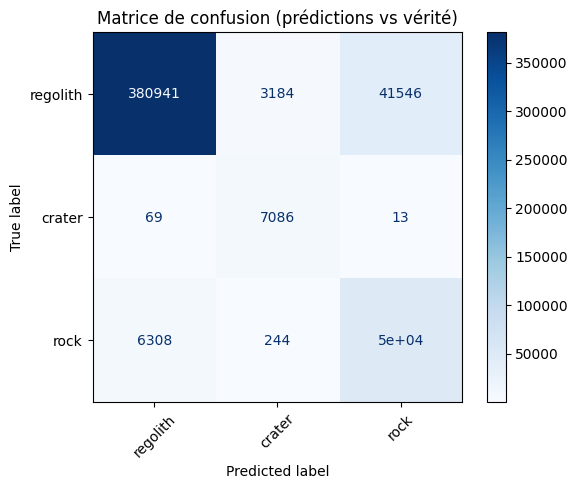

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# noms lisibles des classes
CLASS_NAMES = ["regolith", "crater", "rock"]

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for points, labels in test_loader:
        points, labels = points.to(device), labels.to(device)
        outputs = model(points)  # (B, N, C)
        preds = outputs.argmax(dim=2)  # (B, N)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# flatten all to 1D
y_true = np.concatenate(all_labels).flatten()
y_pred = np.concatenate(all_preds).flatten()

# 🔍 Rapport complet
print("🔍 Rapport par classe :")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# 🧮 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap="Blues", xticks_rotation=45)
disp.ax_.set_title("Matrice de confusion (prédictions vs vérité)")
#plt.show()

# 🧠 mIoU manuel
ious = []
for cls in range(len(CLASS_NAMES)):
    tp = np.logical_and(y_pred == cls, y_true == cls).sum()
    fp = np.logical_and(y_pred == cls, y_true != cls).sum()
    fn = np.logical_and(y_pred != cls, y_true == cls).sum()
    denom = tp + fp + fn
    iou = tp / denom if denom != 0 else float("nan")
    ious.append(iou)

print("📊 IoU par classe :")
for cls, iou in zip(CLASS_NAMES, ious):
    print(f" - {cls:10s} : {iou:.4f}")

print(f"\n📈 mIoU global : {np.nanmean(ious):.4f}")


In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch

# -- Définition des classes/couleurs
CATEGORY_NAMES = {
    -1: "regolith",
     0: "crater",
   174: "rock"
}

CATEGORY_COLORS = {
    -1: "#BB469C",  # regolith
     0: "#7800C8",  # crater
   174: "#E8FA50"   # rock
}

def label_to_rgb(cat):
    hex_color = CATEGORY_COLORS.get(cat, "#BBBBBB")
    return tuple(int(hex_color.lstrip("#")[i:i+2], 16) for i in (0, 2, 4))

def project_points(points_cam, K):
    mask = points_cam[:, 2] > 0
    pts = points_cam[mask]
    if pts.shape[0] == 0:
        return np.zeros((0,2)), np.zeros(0), mask
    pts_2d = (K @ pts.T).T
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:3]
    return pts_2d, pts[:, 2], mask

def validate_npz_compare_preds(i, model, device, folder="data/moon/"):
    # -- chercher le fichier
    files = sorted([f for f in os.listdir(folder) if f.endswith(".npz")])
    if i >= len(files):
        raise IndexError(f"Index {i} hors limite, {len(files)} fichiers trouvés.")
    path = os.path.join(folder, files[i])
    print(f"📂 Fichier sélectionné : {files[i]}")

    # -- charger les données
    data = np.load(path, allow_pickle=True)
    lidar_points = data["lidar_points"]
    lidar_cat = data["lidar_category"]
    img = data["image_left"]


    # -- prédictions
    model.eval()
    with torch.no_grad():
        pts_tensor = torch.tensor(lidar_points, dtype=torch.float32).unsqueeze(0).to(device)
        logits = model(pts_tensor)
        preds = logits.argmax(dim=-1).squeeze(0).cpu().numpy()

    # -- stats
    cat_counts = Counter(lidar_cat)
    pred_counts = Counter(preds)

    # -- reprojection
    points_cam = np.zeros_like(lidar_points)
    points_cam[:, 0] = lidar_points[:, 1]
    points_cam[:, 1] = lidar_points[:, 2]
    points_cam[:, 2] = lidar_points[:, 0]

    K = np.array([[680, 0, 512], [0, 680, 288], [0, 0, 1]], dtype=np.float32)
    h, w, _ = img.shape
    pts_2d, _, mask = project_points(points_cam, K)
    u = pts_2d[:, 0]
    v = pts_2d[:, 1]
    in_bounds = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    final_mask = mask.copy()
    final_mask[mask] = in_bounds

    pts_2d_in = pts_2d[in_bounds]
    true_labels_in = lidar_cat[final_mask]
    pred_labels_in = preds[final_mask]

    CLASS_MAPPING = {0: -1, 1: 0, 2: 174}
    mapped_preds = np.array([CLASS_MAPPING.get(int(l), -1) for l in pred_labels_in])

    rgb_true = np.array([label_to_rgb(int(l)) for l in true_labels_in]) / 255.
    rgb_pred = np.array([label_to_rgb(int(l)) for l in mapped_preds]) / 255.

    # -- affichage côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(img)
    axes[0].scatter(pts_2d_in[:, 0], pts_2d_in[:, 1], c=rgb_true, s=3, alpha=0.4)
    axes[0].set_title("LiDAR → VRAIES classes")
    axes[0].axis("off")

    axes[1].imshow(img)
    axes[1].scatter(pts_2d_in[:, 0], pts_2d_in[:, 1], c=rgb_pred, s=3, alpha=0.4)
    axes[1].set_title("LiDAR → PRÉDICTIONS PointNet")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


    print(f"  → lidar_points : {lidar_points.shape} | lidar_category : {lidar_cat.shape} | image : {img.shape}")
    
    print("\n📊 Vraies classes :")
    for k in sorted(cat_counts):
        print(f"  - {k:>4} ({CATEGORY_NAMES.get(k, '???')}) : {cat_counts[k]:>6} points")

    print("\n🔮 Prédictions PointNet :")
    for k in sorted(pred_counts):
        name = ["regolith", "crater", "rock"][k] if k in [0,1,2] else "???"
        print(f"  - {k:>4} ({name}) : {pred_counts[k]:>6} points")

📂 Fichier sélectionné : 1692601835748890368.npz


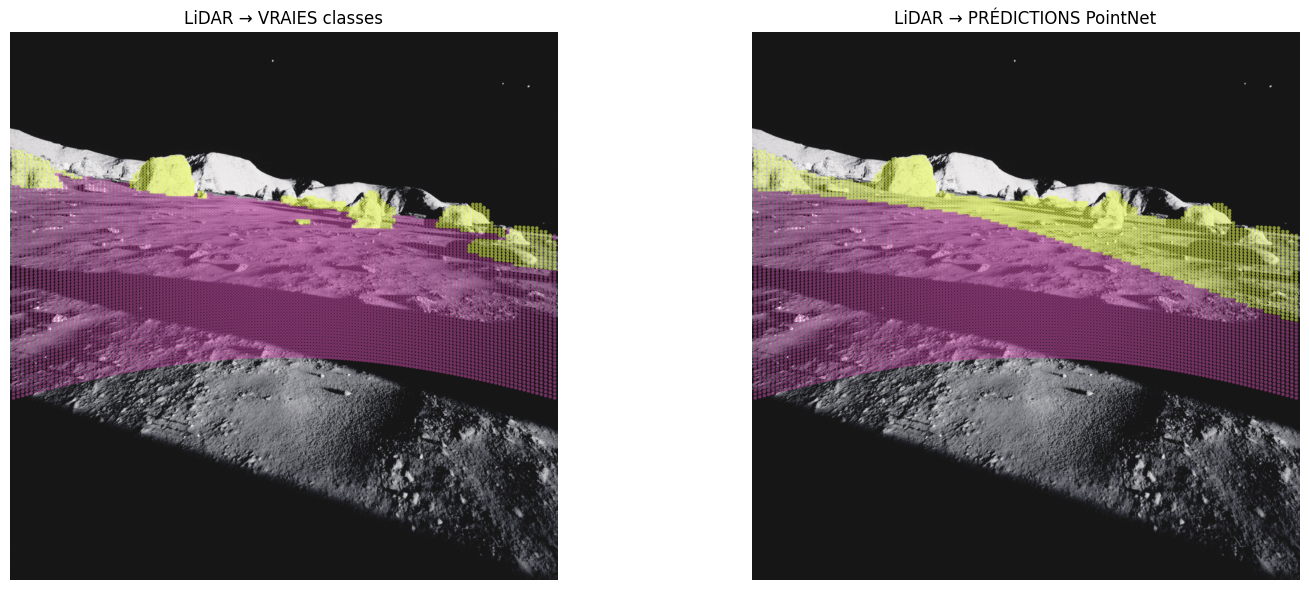

  → lidar_points : (46422, 3) | lidar_category : (46422,) | image : (1024, 1024, 3)

📊 Vraies classes :
  -   -1 (regolith) :  34745 points
  -    0 (crater) :   3600 points
  -  174 (rock) :   8077 points

🔮 Prédictions PointNet :
  -    0 (regolith) :  27879 points
  -    1 (crater) :   5732 points
  -    2 (rock) :  12811 points


In [45]:
validate_npz_compare_preds(195, model, device)

c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


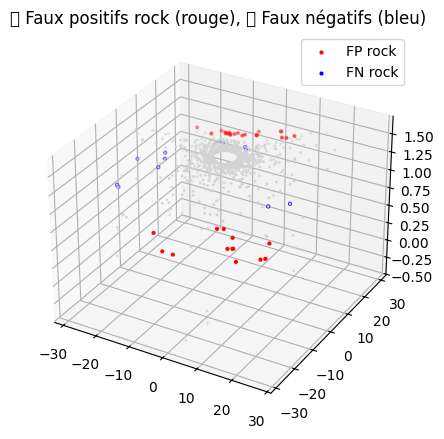

In [50]:
# ➤ chargement du meilleur modèle
model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
model.eval()

# ➤ exemple d’erreurs typiques : afficher faux positifs rock
for points, labels in test_loader:
    points, labels = points.to(device), labels.to(device)
    outputs = model(points)
    preds = outputs.argmax(dim=2)
    break  # on prend juste le premier batch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

i = 0  # premier exemple du batch
pc = points[i].cpu().numpy()
true = labels[i].cpu().numpy()
pred = preds[i].cpu().numpy()

mask_fp_rock = (pred == 2) & (true != 2)
mask_fn_rock = (pred != 2) & (true == 2)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="3d")
ax.set_title("🟥 Faux positifs rock (rouge), 🟦 Faux négatifs (bleu)")

ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c="lightgray", s=1)
ax.scatter(pc[mask_fp_rock, 0], pc[mask_fp_rock, 1], pc[mask_fp_rock, 2], c="red", s=4, label="FP rock")
ax.scatter(pc[mask_fn_rock, 0], pc[mask_fn_rock, 1], pc[mask_fn_rock, 2], c="blue", s=4, label="FN rock")
ax.legend()
plt.show()


In [51]:
model.eval()
correct = total = 0

with torch.no_grad():
    for points, labels in test_loader:
        points, labels = points.to(device), labels.to(device)
        outputs = model(points)
        preds = outputs.argmax(dim=2)

        correct += (preds == labels).sum().item()
        total += labels.numel()

acc = 100 * correct / total
print(f"🎯 Accuracy totale (point-wise) : {acc:.2f}%")


🎯 Accuracy totale (point-wise) : 90.41%


C:\Users\theog\AppData\Local\Temp\ipykernel_18488\38495407.py:35: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\theog\AppData\Local\Temp\ipykernel_18488\38495407.py:35: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


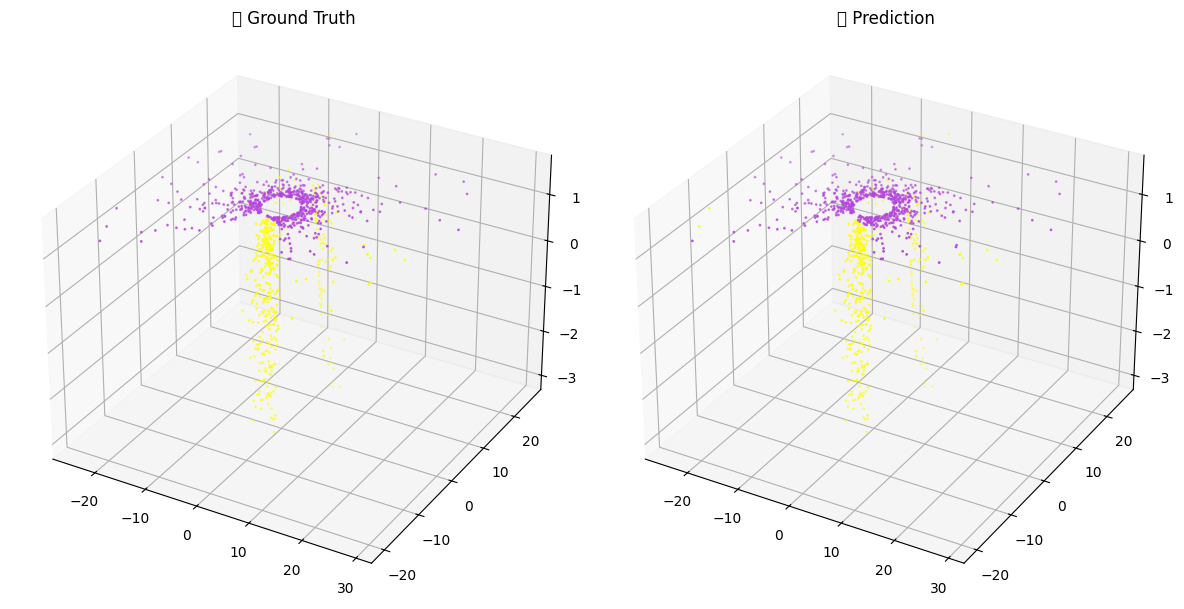

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# couleurs simples par classe
colors = np.array([
    [180, 70, 220],    # regolith - classe 0
    [0, 180, 255],     # crater - classe 1
    [255, 255, 0],     # rock - classe 2
]) / 255.0

# prendre un batch
points, labels = next(iter(test_loader))
points, labels = points.to(device), labels.to(device)
outputs = model(points)
preds = outputs.argmax(dim=2)  # (B, N)

# prendre le premier échantillon du batch
i = 5
pc = points[i].cpu().numpy()        # (N, 3)
gt = labels[i].cpu().numpy()        # (N,)
pr = preds[i].cpu().numpy()         # (N,)

fig = plt.figure(figsize=(12, 6))

# ➤ subplot 1 : Ground Truth
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("🟩 Ground Truth")
ax1.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colors[gt], s=1)

# ➤ subplot 2 : Prediction
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("🔷 Prediction")
ax2.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colors[pr], s=1)

plt.tight_layout()
plt.show()


In [54]:
dataset_path = "data/moon"  # adapter si besoin
full_dataset = LuSNARDataset(dataset_path)

total_files = len(full_dataset)
train_files = int(0.8 * total_files)
val_files = int(0.1 * total_files)
test_files = total_files - train_files - val_files

print(f"📂 Fichiers utilisés :")
print(f" - Train : {train_files} fichiers → {train_files * 1024} points")
print(f" - Val   : {val_files} fichiers → {val_files * 1024} points")
print(f" - Test  : {test_files} fichiers → {test_files * 1024} points")
print(f" - Total : {total_files} fichiers → {total_files * 1024} points")


📂 Fichiers utilisés :
 - Train : 3824 fichiers → 3915776 points
 - Val   : 478 fichiers → 489472 points
 - Test  : 478 fichiers → 489472 points
 - Total : 4780 fichiers → 4894720 points
